In [91]:
import pandas as pd
import numpy as np
import seaborn as sns 

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

from tqdm import tqdm 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

import nltk
import pymorphy2
import re
from nltk.corpus import stopwords

In [2]:
tf.__version__

'2.7.0'

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
df = pd.read_csv('Data/reviews_preprocessed.csv')
df.head()

,Unnamed: 0,author,date,product_id,product_name,rate,text
0,0,Егор Гумеров,15.10.2017,888880022374,АКУСТИЧЕСКАЯ ГИТАРА STAGG SA20D RED,4,это мой первый гитара консультант ответить на ...
1,1,Гость,15.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,пожалуйста сказать кто нибыть у кто он есть та...
2,2,Гость,03.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,5,клёвый вещь ка быть в мск
3,3,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,прийтись снизить оценка так к высниться что по...
4,4,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,4,под хр сразу не заработать дрова надо везти с ...


In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,author,date,product_id,product_name,rate,text
0,Егор Гумеров,15.10.2017,888880022374,АКУСТИЧЕСКАЯ ГИТАРА STAGG SA20D RED,4,это мой первый гитара консультант ответить на ...
1,Гость,15.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,пожалуйста сказать кто нибыть у кто он есть та...
2,Гость,03.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,5,клёвый вещь ка быть в мск
3,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,прийтись снизить оценка так к высниться что по...
4,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,4,под хр сразу не заработать дрова надо везти с ...


<AxesSubplot:xlabel='rate', ylabel='count'>

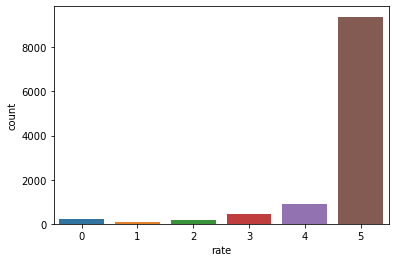

In [92]:
sns.countplot(x='rate', data=df)

In [6]:
sentences_length = [len(review.split()) for review in df.text]

In [7]:
print(f'Самый короткий отзыв содержит {min(sentences_length)} слов')
print(f'Самый длинный отзыв содержит {max(sentences_length)} слов')

Самый короткий отзыв содержит 1 слов
Самый длинный отзыв содержит 606 слов


In [8]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'

In [9]:
model = hub.load(module_url)

In [10]:
def embed_text(input):
    return model(input)

#### reviews embeddings 'as-is'

Подаю в модель отзывы как есть, с предварительной предобработкой (лемматизация). Узкое место - различная длина отзывов от 1 слова в составе до 606, и все они будут закодированны единообразно, вектором из 512 чисел.

In [11]:
embeds = [embed_text(review) for review in tqdm(df.text)]

100%|████████████████████████████████████████████████████████████████████████████| 11185/11185 [12:35<00:00, 14.80it/s]


In [12]:
embeds[0].shape

TensorShape([1, 512])

In [13]:
features = [np.array(emb).tolist()[0] for emb in embeds]

In [14]:
print(f'всего отзывов {len(features)}')
print(f'длина 1 вектора {len(features[0])}')

всего отзывов 11185
длина 1 вектора 512


### Baseline 

In [16]:
x_train, x_test, y_train, y_test = train_test_split(features, df.rate, stratify=df.rate, test_size=0.25) 

In [17]:
lr = LogisticRegression(max_iter=5000)
lr.fit(x_train, y_train)

LogisticRegression(max_iter=5000)

In [18]:
y_pred = lr.predict(x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         3
           3       0.02      0.29      0.03         7
           4       0.01      0.38      0.03         8
           5       1.00      0.84      0.91      2779

    accuracy                           0.84      2797
   macro avg       0.17      0.25      0.16      2797
weighted avg       0.99      0.84      0.91      2797



Модель не справляется с дисбалансом классов.

### Other classifiers

In [19]:
classifiers = {
    'lr_l1':LogisticRegression(penalty='l1', C=0.1, solver='saga'),
    'lr_l2':LogisticRegression(penalty='l2', C=0.1, solver='saga'),
    'tree':DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(), 
    'knc': KNeighborsClassifier(n_neighbors=7),
    'svc': SVC()
}

In [20]:
def train_and_predict(model, x_train, x_test, y_train, y_test):
    '''
    Обучение модели классификации и вывод результатов
    '''
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'{model.__class__.__name__} result')
    print(classification_report(y_pred, y_test))
    print('----------------------------------')

In [21]:
for classifier in classifiers.values():
    train_and_predict(classifier, x_train, x_test, y_train, y_test)

LogisticRegression result
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.84      0.91      2797

    accuracy                           0.84      2797
   macro avg       0.17      0.14      0.15      2797
weighted avg       1.00      0.84      0.91      2797

----------------------------------
LogisticRegression result
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.84      0.91  

С учетом дисбаланса классов наиболее убедительный результат показывают методы random forest, decision tree и K-neighbors classifiers, но и то преимущественно за угадывание самого распространенного класса. 

### Oversampling

Стратегия 1: добавить в наименее представленные классы некоторое количество искусственных значений, меньшее, чем количество элементов самого представленного класса. Тем самым сохраняем некоторое начальное представление низких оценок мало, средних чуть больше, хороших - много. 

In [22]:
strategy = {0:1000, 1:1000, 2:2000, 3:2000, 4:2000}

In [23]:
oversample = SMOTE(sampling_strategy=strategy, k_neighbors=5)
X_new, Y_new = oversample.fit_resample(features, df.rate)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.25, stratify=Y_new)

In [25]:
lr = LogisticRegression(max_iter=5000)
train_and_predict(lr, x_train, x_test, y_train, y_test)

LogisticRegression result
              precision    recall  f1-score   support

           0       0.06      0.50      0.10        28
           1       0.81      0.92      0.86       220
           2       0.78      0.76      0.77       516
           3       0.46      0.62      0.53       369
           4       0.15      0.46      0.22       157
           5       0.92      0.71      0.80      3057

    accuracy                           0.71      4347
   macro avg       0.53      0.66      0.55      4347
weighted avg       0.83      0.71      0.75      4347

----------------------------------


In [28]:
# проверим, как изменяется accuracy в зависимости от количества k соседей, по которым рассчитываются искусственные значения
for k in range(3, 10):
    oversample = SMOTE(sampling_strategy=strategy, k_neighbors=k)
    X_new, Y_new = oversample.fit_resample(features, df.rate)
    x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.25, stratify=Y_new)
    lr = LogisticRegression(max_iter=5000)
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    print(f'for k = {k} acc = {accuracy_score(y_pred, y_test)}')
    

for k = 3 acc = 0.714975845410628
for k = 4 acc = 0.7129054520358868
for k = 5 acc = 0.7204968944099379
for k = 6 acc = 0.7181964573268921
for k = 7 acc = 0.7158960202438464
for k = 8 acc = 0.7057740970784449
for k = 9 acc = 0.7094547964113181


Результаты колеблются незначительно. 

Стратегия 2: сэмплировать значения всех классов, кроме класса с большинством, сравняв количество значений в них

In [29]:
for k in range(3, 10):
    oversample = SMOTE(sampling_strategy='not majority', k_neighbors=k)
    X_new, Y_new = oversample.fit_resample(features, df.rate)
    x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.25, stratify=Y_new)
    lr = LogisticRegression(max_iter=5000)
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    print(f'for k = {k} acc = {accuracy_score(y_pred, y_test)}')

for k = 3 acc = 0.806733432772214
for k = 4 acc = 0.7948007670999361
for k = 5 acc = 0.805668016194332
for k = 6 acc = 0.7995596278144754
for k = 7 acc = 0.7973577668868528
for k = 8 acc = 0.800411961076781
for k = 9 acc = 0.7974287946587115


Применим прочие классификаторы к данным, сэмплированным по стратегии с наибольшей accuracy на baseline 

In [30]:
oversample = SMOTE(sampling_strategy='not majority', k_neighbors=3)
X_new, Y_new = oversample.fit_resample(features, df.rate)
x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.25, stratify=Y_new)
for classifier in classifiers.values():
    train_and_predict(classifier, x_train, x_test, y_train, y_test)

LogisticRegression result
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      2901
           1       0.97      0.86      0.91      2652
           2       0.86      0.77      0.81      2596
           3       0.59      0.63      0.61      2203
           4       0.50      0.57      0.54      2054
           5       0.37      0.53      0.44      1673

    accuracy                           0.69     14079
   macro avg       0.69      0.67      0.67     14079
weighted avg       0.72      0.69      0.70     14079

----------------------------------
LogisticRegression result
              precision    recall  f1-score   support

           0       0.80      0.66      0.72      2872
           1       0.98      0.85      0.91      2701
           2       0.85      0.77      0.81      2569
           3       0.60      0.65      0.62      2161
           4       0.53      0.60      0.56      2094
           5       0.40      0.56      0.47  

SVC и RFC дают 0,99 accuracy, что вроде хорошо, но немного настораживает и заставляет задуматься, а не переобучилась ли модель

### Новый подход к эмбеддингам:
эмбеддинг отзыва - усреднение эмббедингов предложений. Должно получится более адекватное представление для отзывов очень большой длины.

In [31]:
df_orig = pd.read_csv('Data/reviews.csv')

In [32]:
df_orig.drop('Unnamed: 0', axis=1, inplace=True)

In [33]:
stops = stopwords.words('russian')

In [34]:
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')

In [35]:
morph = pymorphy2.MorphAnalyzer()

In [36]:
def review_to_wordlist(review, remove_stopwords=False ):

    # оставляем только буквенные символы
    review_text = re.sub("[^А-Яа-я]"," ", review)
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    words = review_text.lower().split()
    words_lemmatized = [morph.parse(w)[0].normal_form for w in words]
    if remove_stopwords: # убираем стоп-слова
        words_lemmatized = [w for w in words_lemmatized if not w in stops]
    return(' '.join(words_lemmatized))

def review_to_sentences(review, tokenizer, remove_stopwords=False):
    # разбиваем обзор на предложения
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    # применяем предыдущую функцию к каждому предложению
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [37]:
review_to_sentences('Мы не знали друг друга до этого лета. Мы болтались по свету, земле и воде', tokenizer)

['мы не знать друг друг до это лето', 'мы болтаться по свет земля и вода']

In [38]:
df_orig.isnull().sum()

author          5
date            0
product_id      0
product_name    0
rate            0
text            1
dtype: int64

In [39]:
df_orig['author'] =  df_orig['author'].fillna('Неизвестен')

In [40]:
df_orig = df_orig.dropna()

In [41]:
df_orig.isnull().sum()

author          0
date            0
product_id      0
product_name    0
rate            0
text            0
dtype: int64

In [42]:
df_orig.head()

,author,date,product_id,product_name,rate,text
0,Егор Гумеров,15.10.2017,888880022374,АКУСТИЧЕСКАЯ ГИТАРА STAGG SA20D RED,4,Это моя первая гитара. Консультант ответил на ...
1,Гость,15.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,Пожалуйста скажите кто-нибудь у кого он есть т...
2,Гость,03.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,5,клевая вещь. ка будет в МСК?
3,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,Пришлось снизить оценку -1 т.к. выснилось что ...
4,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,4,"Под ХР сразу не заработал, дрова надо везти с ..."


In [43]:
df_orig['sentences'] = df_orig['text'].apply(lambda x: review_to_sentences(x, tokenizer))

In [44]:
df_orig.head()

,author,date,product_id,product_name,rate,text,sentences
0,Егор Гумеров,15.10.2017,888880022374,АКУСТИЧЕСКАЯ ГИТАРА STAGG SA20D RED,4,Это моя первая гитара. Консультант ответил на ...,"[это мой первый гитара, консультант ответить н..."
1,Гость,15.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,Пожалуйста скажите кто-нибудь у кого он есть т...,[пожалуйста сказать кто нибыть у кто он есть т...
2,Гость,03.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,5,клевая вещь. ка будет в МСК?,"[клёвый вещь, ка быть в мск]"
3,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,Пришлось снизить оценку -1 т.к. выснилось что ...,[прийтись снизить оценка так к высниться что п...
4,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,4,"Под ХР сразу не заработал, дрова надо везти с ...",[под хр сразу не заработать дрова надо везти с...


In [45]:
def get_avg_embed(sentences):
    vectors = [embed_text(sent) for sent in sentences]
    features = [np.array(vec)[0] for vec in vectors]
    return sum(features)/len(features)
    
    

In [46]:
test = df_orig.sentences.iloc[0]
test

['это мой первый гитара',
 'консультант ответить на всё мой вопрос быстро оформить покупка сам гитара дойти из спб до ухта рк весь за день',
 'взять гитара в рука обнаружить что гриф прогнуться а ведь именно это я и бояться',
 'но ничего в комплект идти шестигранник подкрутить гриф без особый проблема',
 'ещё струна значительно возвышаться над весь остальной прийтись подпилить порожек',
 'сам гитара приятный по звук удобно лежать в рука и после небольшой шаманство петь и плясать',
 'крайне рекомендовать к покупка']

In [151]:
feats = get_avg_embed(test)
feats.shape

(512,)

In [153]:
vectors = [get_avg_embed(sents) for sents in tqdm(df_orig.sentences)]

100%|████████████████████████████████████████████████████████████████████████████| 11213/11213 [29:08<00:00,  6.41it/s]


In [154]:
np_vec = np.array(vectors)

In [155]:
np_vec.shape

(11213, 512)

In [156]:
np.save('features_v1_avg', np_vec)

In [47]:
vectors = np.load('features_v1_avg.npy')

In [48]:
vectors.shape

(11213, 512)

In [49]:
x_train, x_test, y_train, y_test = train_test_split(vectors, df_orig.rate, stratify=df_orig.rate)

In [50]:
lr = LogisticRegression(max_iter=5000)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.04      0.67      0.07         6
           4       0.01      0.33      0.03         9
           5       1.00      0.84      0.91      2789

    accuracy                           0.84      2804
   macro avg       0.17      0.31      0.17      2804
weighted avg       0.99      0.84      0.91      2804



In [51]:
for classifier in classifiers.values():
    train_and_predict(classifier, x_train, x_test, y_train, y_test)

LogisticRegression result
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.84      0.91      2804

    accuracy                           0.84      2804
   macro avg       0.17      0.14      0.15      2804
weighted avg       1.00      0.84      0.91      2804

----------------------------------
LogisticRegression result
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.84      0.91  

результаты отличаются незначительно от полученных на предыдущем этапе с эмбеддингами без усреднения по предложениям. 

### усредненные эмбеддинги + SMOTE

**Стратегия 1** 

In [53]:
oversample = SMOTE(sampling_strategy=strategy, k_neighbors=3)
X_new, Y_new = oversample.fit_resample(vectors, df_orig.rate)
x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.25, stratify=Y_new)

for name, classifier in classifiers.items(): # не будем рассматривать лог.регрессии с пенальти
    if name in ['lr_l1', 'lr_l2']:
        continue 
    train_and_predict(classifier, x_train, x_test, y_train, y_test)

DecisionTreeClassifier result
              precision    recall  f1-score   support

           0       0.62      0.57      0.59       272
           1       0.85      0.84      0.85       251
           2       0.87      0.82      0.85       528
           3       0.74      0.65      0.69       567
           4       0.56      0.52      0.54       541
           5       0.78      0.84      0.81      2193

    accuracy                           0.76      4352
   macro avg       0.74      0.71      0.72      4352
weighted avg       0.75      0.76      0.75      4352

----------------------------------
RandomForestClassifier result
              precision    recall  f1-score   support

           0       0.66      0.99      0.80       167
           1       0.96      1.00      0.98       240
           2       0.97      1.00      0.98       487
           3       0.83      0.98      0.90       422
           4       0.56      0.99      0.72       282
           5       1.00      0.85    

**Стратегия 2**

In [54]:
oversample = SMOTE(sampling_strategy='not majority', k_neighbors=3)
X_new, Y_new = oversample.fit_resample(vectors, df_orig.rate)
x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.25, stratify=Y_new)

for name, classifier in classifiers.items(): 
    if name in ['lr_l1', 'lr_l2']:
        continue 
    train_and_predict(classifier, x_train, x_test, y_train, y_test)

DecisionTreeClassifier result
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2436
           1       0.99      0.97      0.98      2399
           2       0.97      0.95      0.96      2407
           3       0.93      0.90      0.92      2448
           4       0.88      0.83      0.85      2497
           5       0.67      0.82      0.74      1925

    accuracy                           0.90     14112
   macro avg       0.90      0.90      0.90     14112
weighted avg       0.91      0.90      0.90     14112

----------------------------------
RandomForestClassifier result
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2354
           1       1.00      1.00      1.00      2353
           2       1.00      1.00      1.00      2355
           3       1.00      0.99      1.00      2363
           4       0.98      0.97      0.98      2374
           5       0.96      0.98    

### дополнительный датасет (отзывы с другого сайта) как тестовый

In [55]:
df_test = pd.read_csv('Data/reviews_musicstore.csv')
df_test.head()

,Unnamed: 0,author,date,product_id,product_name,firm,rate,text,topic
0,0,Денис,19.2.20,GIT0029798-000,EB2146 12-54 Earthwood Phosphor Bronze Regular...,Ernie Ball,5,Тут как всегда - отличное качество и звучание,Супер
1,1,Olga Soboleva,11.8.16,PAH0007008-000,"ZED-12FX 6 x mono, 3 x stereo, USB, FX",Allen & Heath,5,За недорогую цену хорошего качества микшер...,"Недорого и качественно, хороший микшер."
2,2,Иван,18.11.20,PCM0014110-000,,ESI,5,Доставка и упаковка как всегда на высоте. Карт...,Карта Esi 22 xt
3,3,лютый,14.2.20,GIT0039047-000,Cleaning Cloth,Fame,5,"Типичная гитарная тряпочка, без переплаты",Нормальная салфетка
4,4,Artem,16.6.19,PCM0015562-000,Studio 24C,Presonus,5,Ни так давно попробовал DAW Presonus Studio On...,"Классная звуковая, и классный софт в комплекте..."


In [56]:
df_test = df_test[['rate', 'text']]

In [57]:
df_test.rate.value_counts()

5    5307
4     627
3      73
2      19
1       8
0       6
Name: rate, dtype: int64

In [58]:
df_test['sentences'] = df_test['text'].apply(lambda x: review_to_sentences(x, tokenizer))

In [59]:
df_test.head()

,rate,text,sentences
0,5,Тут как всегда - отличное качество и звучание,[тут как всегда отличный качество и звучание]
1,5,За недорогую цену хорошего качества микшер...,[за недорогой цена хороший качество микшерный ...
2,5,Доставка и упаковка как всегда на высоте. Карт...,"[доставка и упаковка как всегда на высота, кар..."
3,5,"Типичная гитарная тряпочка, без переплаты",[типичный гитарный тряпочка без переплата]
4,5,Ни так давно попробовал DAW Presonus Studio On...,[ни так давно попробовать потестировать неделя...


In [60]:
df_test.isnull().sum()

rate         0
text         0
sentences    0
dtype: int64

In [61]:
test_vectors = [get_avg_embed(sents) for sents in tqdm(df_test.sentences)]

100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [14:41<00:00,  6.85it/s]


In [70]:
x_train, y_train = vectors, df_orig.rate
x_test, y_test = test_vectors, df_test.rate

In [71]:
for classifier in classifiers.values(): 
    train_and_predict(classifier, x_train, x_test, y_train, y_test)

LogisticRegression result
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.88      0.94      6040

    accuracy                           0.88      6040
   macro avg       0.17      0.15      0.16      6040
weighted avg       1.00      0.88      0.94      6040

----------------------------------
LogisticRegression result
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.88      0.94  

Модели показывают высокую accuracy только за счет того, что в основном предсказывают самый распространенный класс 5

### Oversampling на основном датасете, проверка на тестовом

**Стратегия 1**

In [68]:
oversample = SMOTE(sampling_strategy=strategy, k_neighbors=5)
X_new, Y_new = oversample.fit_resample(vectors, df_orig.rate)

In [69]:
for classifier in classifiers.values(): 
    train_and_predict(classifier, X_new, test_vectors, Y_new, df_test.rate)

LogisticRegression result
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00        34
           2       0.16      0.01      0.02       223
           3       0.00      0.00      0.00        68
           4       0.00      0.60      0.01         5
           5       0.96      0.89      0.92      5710

    accuracy                           0.84      6040
   macro avg       0.19      0.25      0.16      6040
weighted avg       0.91      0.84      0.87      6040

----------------------------------
LogisticRegression result
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         9
           2       0.21      0.02      0.04       171
           3       0.04      0.03      0.04        88
           4       0.00      0.11      0.01        18
           5       0.96      0.89      0.92  

**Стратегия 2**

In [64]:
oversample = SMOTE(sampling_strategy='not majority', k_neighbors=3)
X_new, Y_new = oversample.fit_resample(vectors, df_orig.rate)

In [67]:
for classifier in classifiers.values(): 
    train_and_predict(classifier, X_new, test_vectors, Y_new, df_test.rate)

LogisticRegression result
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       233
           1       0.25      0.01      0.01       347
           2       0.21      0.01      0.02       323
           3       0.21      0.02      0.04       630
           4       0.49      0.11      0.18      2895
           5       0.29      0.95      0.44      1612

    accuracy                           0.31      6040
   macro avg       0.24      0.18      0.12      6040
weighted avg       0.36      0.31      0.21      6040

----------------------------------
LogisticRegression result
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       129
           1       0.25      0.01      0.01       357
           2       0.11      0.01      0.01       302
           3       0.22      0.02      0.04       646
           4       0.51      0.10      0.17      3082
           5       0.27      0.95      0.42  

Снова низкие скоры для всех оценок, кроме 5